# Tilapia Regression Model with SARIMA
By Miguel Andre R. Pajarillo

## Load the Dataset

In [1]:
import pandas as pd

In [2]:
Tilapia_UN = pd.read_csv('./data/egg_UN.csv')

In [3]:
Tilapia_DA = pd.read_csv('./data/egg_DA_egg_DA.csv.csv')

In [4]:
Tilapia_UN

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,92,Eggs - Retail,33,Unit,1,2009,4.5100
1,92,Eggs - Retail,33,Unit,2,2009,4.5200
2,92,Eggs - Retail,33,Unit,3,2009,4.5400
3,92,Eggs - Retail,33,Unit,4,2009,4.8600
4,92,Eggs - Retail,33,Unit,5,2009,4.8600
...,...,...,...,...,...,...,...
2510,92,Eggs - Retail,33,Unit,10,2020,6.7333
2511,92,Eggs - Retail,33,Unit,11,2020,6.9120
2512,92,Eggs - Retail,33,Unit,12,2020,6.6575
2513,92,Eggs - Retail,33,Unit,1,2021,6.8625


In [5]:
Tilapia_DA.head()

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,NaN,Chicken egg (medium) - Retail,NaN,pc,1,2022,5.98
1,NaN,Chicken egg (medium) - Retail,NaN,pc,2,2022,5.93
2,NaN,Chicken egg (medium) - Retail,NaN,pc,3,2022,5.93
3,NaN,Chicken egg (medium) - Retail,NaN,pc,4,2022,5.93
4,NaN,Chicken egg (medium) - Retail,NaN,pc,5,2022,5.96


## Extract Necessary Columns (Date and Price)

### UN World Food Programme

In [6]:
Tilapia_UN['date'] = pd.to_datetime(
    Tilapia_UN.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [7]:
Tilapia_UN = Tilapia_UN.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [8]:
Tilapia_UN.head()

,mp_price,date
0,4.51,2009-01-15
1,4.52,2009-02-15
2,4.54,2009-03-15
3,4.86,2009-04-15
4,4.86,2009-05-15


### DA Bantay Presyo

In [9]:
Tilapia_DA['date'] = pd.to_datetime(
    Tilapia_DA.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [10]:
Tilapia_DA = Tilapia_DA.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [11]:
Tilapia_DA.head()

,mp_price,date
0,5.98,2022-01-15
1,5.93,2022-02-15
2,5.93,2022-03-15
3,5.93,2022-04-15
4,5.96,2022-05-15


In [12]:
import matplotlib.pyplot as plt

In [13]:
Tilapia = pd.concat([Tilapia_DA, Tilapia_UN])

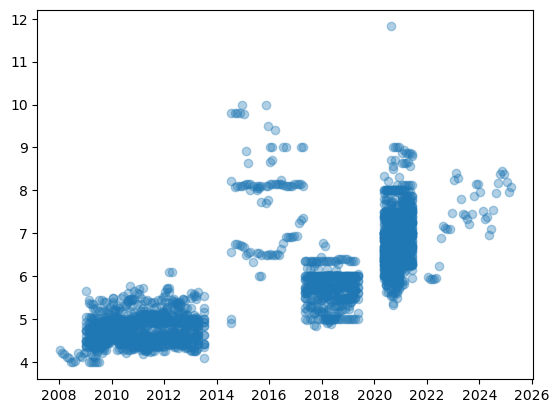

<Figure size 5000x600 with 0 Axes>

In [14]:
plt.scatter(Tilapia['date'], Tilapia['mp_price'], alpha=0.35)
plt.figure(figsize=(50, 6))
plt.show()

In [15]:
from datetime import datetime

In [16]:
# Set Date as the Inex
Tilapia = Tilapia.set_index('date')

In [17]:
# Aggregate samples to mean
Tilapia = Tilapia.resample('MS').mean()

In [18]:
Tilapia['mp_price'] = Tilapia['mp_price'].interpolate(method='linear')

In [19]:
start_date = datetime(2020,1,1)
end_date = datetime(2026,1,1)
lim_tilapia = Tilapia[start_date:end_date]

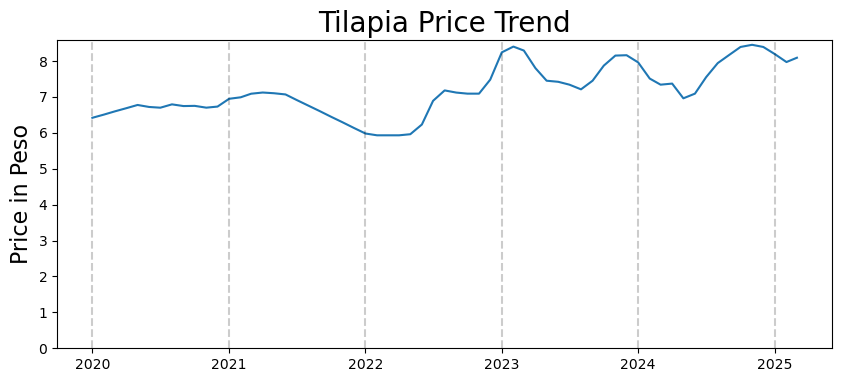

In [20]:
plt.figure(figsize=(10,4))
plt.plot(lim_tilapia)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
plt.ylim(bottom=0)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [21]:
first_diff = lim_tilapia.diff()[1:]

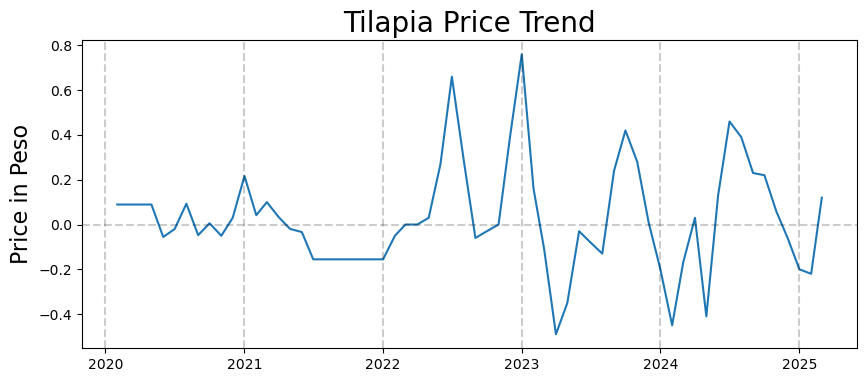

In [22]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

## ACF

In [23]:
from statsmodels.tsa.stattools import acf, pacf

<BarContainer object of 18 artists>

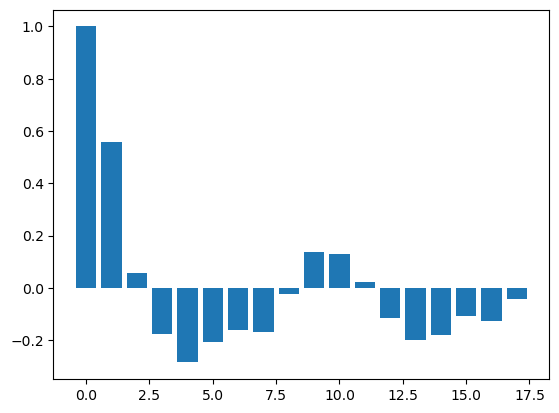

In [24]:
acf_vals = acf(first_diff)
num_lags = 18
plt.bar(range(num_lags), acf_vals[:num_lags])

### Based on ACF, we should start with a seasonal MA process

## PACF

<BarContainer object of 18 artists>

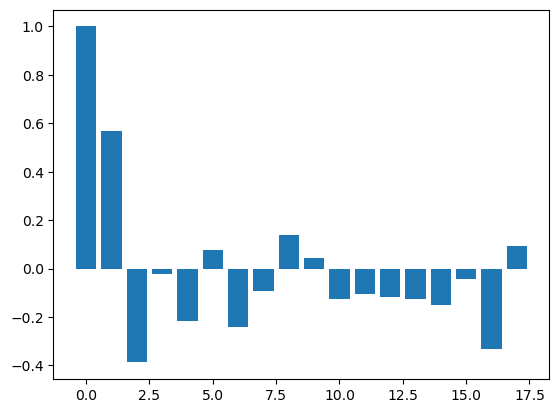

In [25]:
pacf_vals = pacf(first_diff)
num_lags = 18
plt.bar(range(num_lags), pacf_vals[:num_lags])

### Based on PACF, we should start with a seasonal AR process

## Get training and testing sets

In [26]:
from datetime import timedelta

In [27]:
train_end = datetime(2024,9,1)
test_end = datetime(2025,3,1)

train_data = lim_tilapia[:train_end]
test_data = lim_tilapia[train_end + timedelta(days=1):test_end]

In [28]:
Tilapia.describe()

,mp_price
count,207.000000
mean,6.169005
std,1.299101
min,3.990000
25%,4.827555
50%,5.960000
75%,7.340000
max,8.450000


## Fit the SARIMA Model

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [30]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [31]:
from time import time

In [32]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16698D-02    |proj g|=  9.64992D-01

At iterate    5    f= -2.66292D-02    |proj g|=  4.13756D-01

At iterate   10    f= -3.49048D-02    |proj g|=  1.49514D-01

At iterate   15    f= -4.72577D-02    |proj g|=  2.48632D-02

At iterate   20    f= -4.79786D-02    |proj g|=  4.52897D-03


 This problem is unconstrained.



At iterate   25    f= -4.81965D-02    |proj g|=  2.97113D-02

At iterate   30    f= -4.82194D-02    |proj g|=  6.80527D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     40      1     0     0   6.911D-05  -4.822D-02
  F =  -4.8219915975142177E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Model Fitting Time: 0.349550724029541


In [33]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             mp_price   No. Observations:                   57
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                   2.749
Date:                              Thu, 22 May 2025   AIC                              0.503
Time:                                      11:59:42   BIC                              6.579
Sample:                                  01-01-2020   HQIC                             2.859
                                       - 09-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.9808      0.644     -1.522      0.128      -2.243       0.282
ma.S.L12       0.89

In [34]:
print(type(test_data))
print(test_data.columns)
print(test_data.head())

<class 'pandas.core.frame.DataFrame'>
Index(['mp_price'], dtype='object')
            mp_price
date                
2024-10-01      8.39
2024-11-01      8.45
2024-12-01      8.39
2025-01-01      8.19
2025-02-01      7.97


In [35]:
# Assuming test_data is a DataFrame with a single column named "mp_price"
test_series = test_data['mp_price']

In [36]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_series - predictions

In [37]:
predictions

date
2024-10-01    8.124854
2024-11-01    8.097530
2024-12-01    8.175963
2025-01-01    8.362288
2025-02-01    8.443907
2025-03-01    8.454476
Freq: MS, Name: predicted_mean, dtype: float64

In [38]:
residuals

date
2024-10-01    0.265146
2024-11-01    0.352470
2024-12-01    0.214037
2025-01-01   -0.172288
2025-02-01   -0.473907
2025-03-01   -0.364476
Freq: MS, dtype: float64

Text(0, 0.5, 'Error')

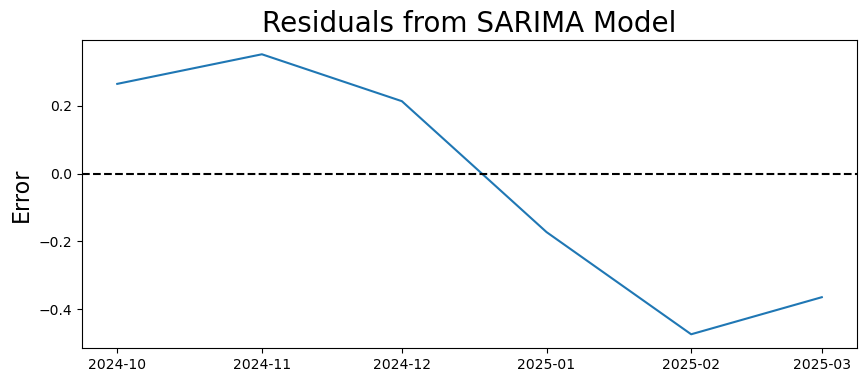

In [39]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

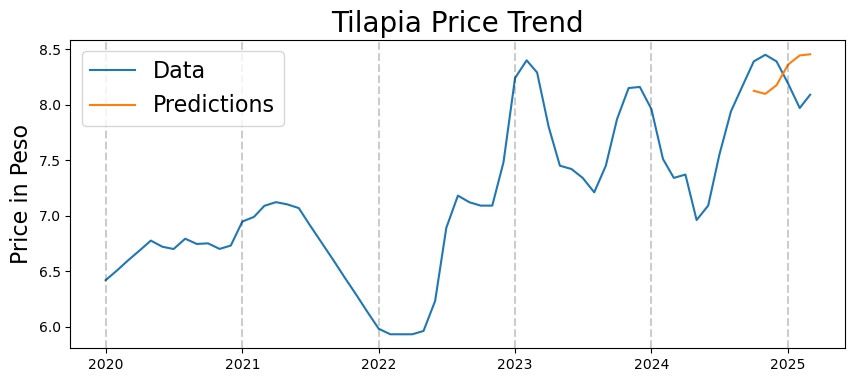

In [40]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Using the Rolling Forecast Origin

In [41]:
rolling_predictions = test_series.copy()
for train_end in test_series.index:
    train_data = lim_tilapia[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16698D-02    |proj g|=  9.64992D-01

At iterate    5    f= -2.66292D-02    |proj g|=  4.13756D-01

At iterate   10    f= -3.49048D-02    |proj g|=  1.49514D-01

At iterate   15    f= -4.72577D-02    |proj g|=  2.48632D-02

At iterate   20    f= -4.79786D-02    |proj g|=  4.52897D-03

At iterate   25    f= -4.81965D-02    |proj g|=  2.97113D-02


 This problem is unconstrained.



At iterate   30    f= -4.82194D-02    |proj g|=  6.80527D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     40      1     0     0   6.911D-05  -4.822D-02
  F =  -4.8219915975142177E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.06417D-02    |proj g|=  3.81044D-01

At iterate    5    f= -3.32762D-02    |proj g|=  1.71006D-02

At iterate   10    f= -3.67050D-02    |proj g|=  1.86944D-01

At iter

/tmp/ipykernel_99618/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.



At iterate   25    f= -4.55378D-02    |proj g|=  4.10168D-03

At iterate   30    f= -4.55988D-02    |proj g|=  7.57196D-03

At iterate   35    f= -4.56327D-02    |proj g|=  3.89763D-03

At iterate   40    f= -4.56464D-02    |proj g|=  2.24782D-04

At iterate   45    f= -4.56512D-02    |proj g|=  4.44069D-03

At iterate   50    f= -4.56516D-02    |proj g|=  4.83036D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     69      1     0     0   4.830D-04  -4.565D-02
  F =  -4.5651621221299565E-002

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/miguel/anaconda3/envs/learning-workspace/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_99618/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.82123D-02    |proj g|=  4.07208D-01

At iterate    5    f= -3.89100D-02    |proj g|=  1.42772D-02

At iterate   10    f= -4.00165D-02    |proj g|=  1.28167D-01

At iterate   15    f= -4.94073D-02    |proj g|=  4.34479D-02

At iterate   20    f= -5.26528D-02    |proj g|=  5.20916D-03

At iterate   25    f= -5.32626D-02    |proj g|=  1.39730D-03

At iterate   30    f= -5.34129D-02    |proj g|=  7.85487D-03

At iterate   35    f= -5.34765D-02    |proj g|=  4.97843D-03

At iterate   40    f= -5.34957D-02    |proj g|=  8.77305D-03

At iterate   45    f= -5.35044D-02    |proj g|=  5.45624D-03

At iterate   50    f= -5.35057D-02    |proj g|=  5.77302D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/miguel/anaconda3/envs/learning-workspace/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_99618/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.



At iterate    5    f= -3.76342D-02    |proj g|=  1.07587D-01

At iterate   10    f= -3.84967D-02    |proj g|=  1.55432D-01

At iterate   15    f= -5.51024D-02    |proj g|=  2.98602D-02

At iterate   20    f= -5.71827D-02    |proj g|=  9.48043D-02

At iterate   25    f= -5.86906D-02    |proj g|=  9.83107D-04

At iterate   30    f= -5.90393D-02    |proj g|=  1.65109D-02

At iterate   35    f= -5.91396D-02    |proj g|=  8.93034D-03

At iterate   40    f= -5.91792D-02    |proj g|=  1.90391D-03

At iterate   45    f= -5.91931D-02    |proj g|=  4.82147D-03

At iterate   50    f= -5.92005D-02    |proj g|=  5.40845D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/miguel/anaconda3/envs/learning-workspace/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_99618/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.



At iterate    5    f= -4.13791D-02    |proj g|=  1.39530D-02

At iterate   10    f= -4.15940D-02    |proj g|=  9.10019D-02

At iterate   15    f= -4.61089D-02    |proj g|=  2.03275D-02

At iterate   20    f= -4.63833D-02    |proj g|=  4.80380D-02

At iterate   25    f= -4.65670D-02    |proj g|=  1.81103D-02

At iterate   30    f= -4.65961D-02    |proj g|=  1.47497D-03

At iterate   35    f= -4.65993D-02    |proj g|=  1.65813D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     39     58      1     0     0   1.287D-04  -4.660D-02
  F =  -4.6599389576350000E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/tmp/ipykernel_99618/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.



At iterate   35    f= -4.30411D-02    |proj g|=  2.31011D-03

At iterate   40    f= -4.30495D-02    |proj g|=  3.91177D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     44     59      1     0     0   2.361D-03  -4.305D-02
  F =  -4.3050935872201934E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/tmp/ipykernel_99618/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred


In [42]:
rolling_residuals = test_series - rolling_predictions

Text(0, 0.5, 'Error')

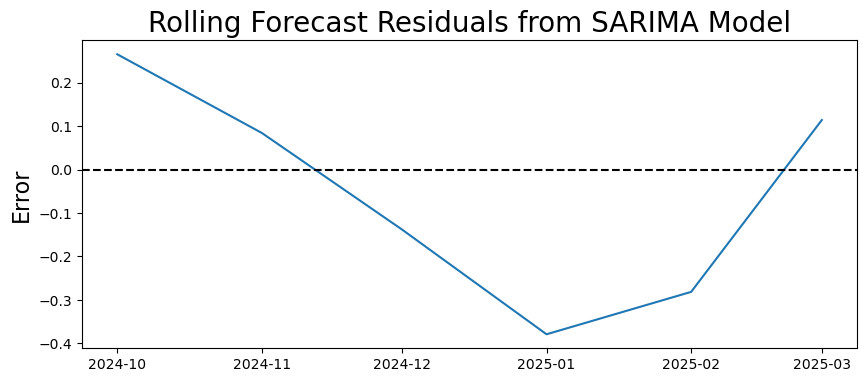

In [43]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

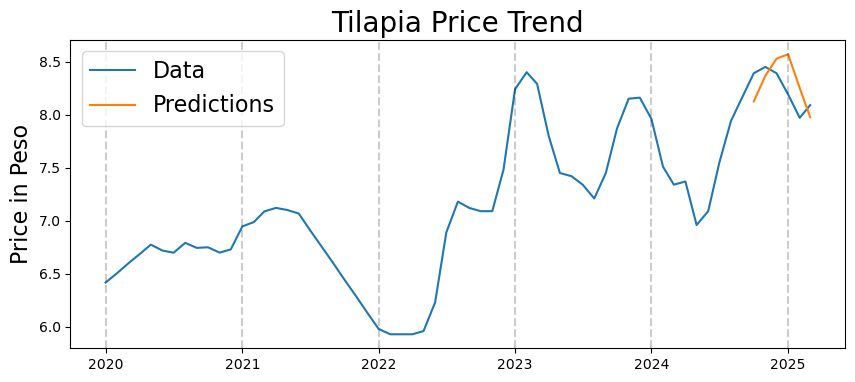

In [44]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [45]:
import numpy as np

In [46]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_series)),4))

Mean Absolute Percent Error: 0.0256


In [47]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 0.23526360003555757


## Future Predictions (2025)

In [48]:
#get the predictions and residuals
predictions = model_fit.forecast(12)
# predictions = pd.Series(predictions, index=test_data.index)
residuals = test_series - predictions

In [49]:
predictions

2025-03-01    7.976161
2025-04-01    7.926521
2025-05-01    7.919905
2025-06-01    7.884746
2025-07-01    7.769741
2025-08-01    7.678597
2025-09-01    7.675285
2025-10-01    7.681237
2025-11-01    7.691149
2025-12-01    7.647773
2026-01-01    7.550621
2026-02-01    7.519533
Freq: MS, Name: predicted_mean, dtype: float64

In [50]:
residuals

2024-10-01         NaN
2024-11-01         NaN
2024-12-01         NaN
2025-01-01         NaN
2025-02-01         NaN
2025-03-01    0.113839
2025-04-01         NaN
2025-05-01         NaN
2025-06-01         NaN
2025-07-01         NaN
2025-08-01         NaN
2025-09-01         NaN
2025-10-01         NaN
2025-11-01         NaN
2025-12-01         NaN
2026-01-01         NaN
2026-02-01         NaN
Freq: MS, dtype: float64

Text(0, 0.5, 'Error')

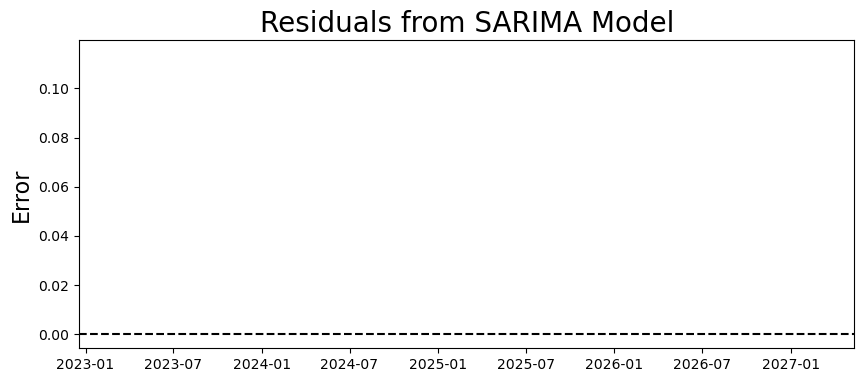

In [51]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

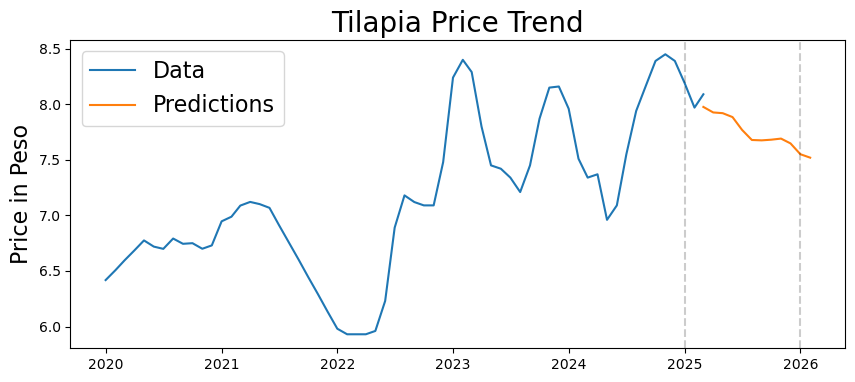

In [52]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(2025,2027):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [53]:
# Tilapia 100g
protein = 12.3
carbs = 1.4
fats = 9.4
fiber = 0

In [54]:
protein_projection = protein / predictions

Text(0, 0.5, 'Protein in Grams')

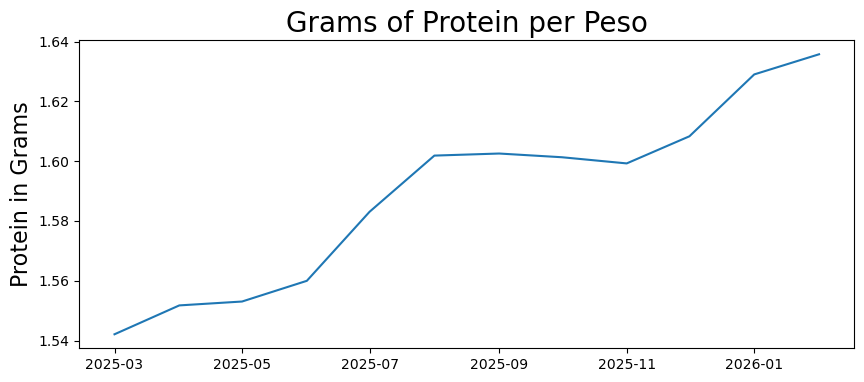

In [55]:
plt.figure(figsize=(10,4))

plt.plot(protein_projection)

plt.title('Grams of Protein per Peso', fontsize=20)
plt.ylabel('Protein in Grams', fontsize=16)

In [56]:
carbs_projection = carbs / predictions

Text(0, 0.5, 'Protein in Grams')

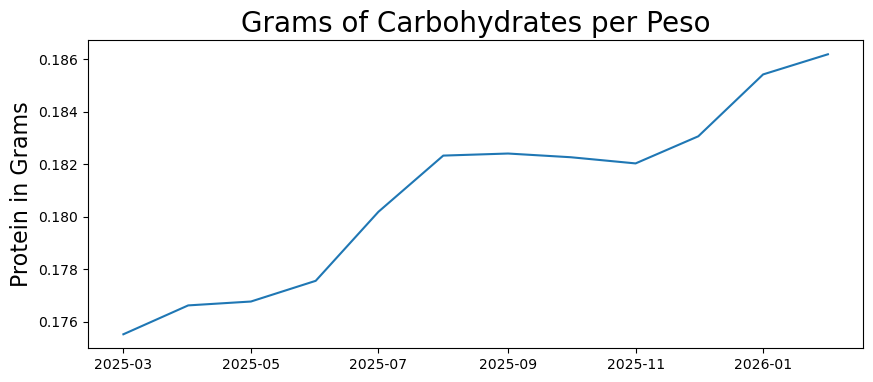

In [57]:
plt.figure(figsize=(10,4))

plt.plot(carbs_projection)

plt.title('Grams of Carbohydrates per Peso', fontsize=20)
plt.ylabel('Protein in Grams', fontsize=16)

In [58]:
fats_projection = fats / predictions

Text(0, 0.5, 'Protein in Grams')

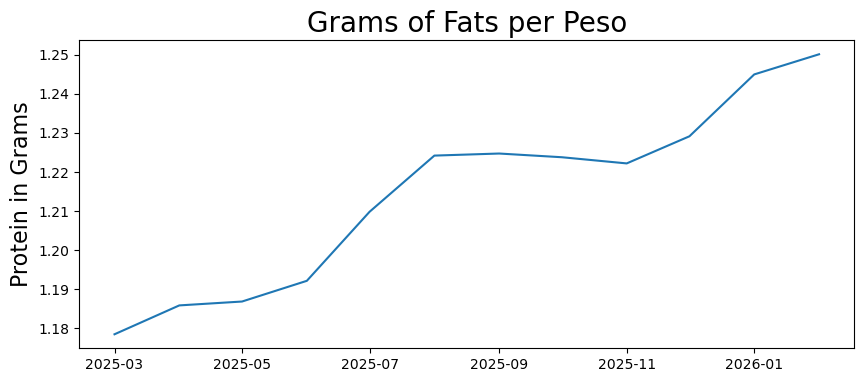

In [59]:
plt.figure(figsize=(10,4))

plt.plot(fats_projection)

plt.title('Grams of Fats per Peso', fontsize=20)
plt.ylabel('Protein in Grams', fontsize=16)

In [60]:
fiber_projection = fiber / predictions

Text(0, 0.5, 'Protein in Grams')

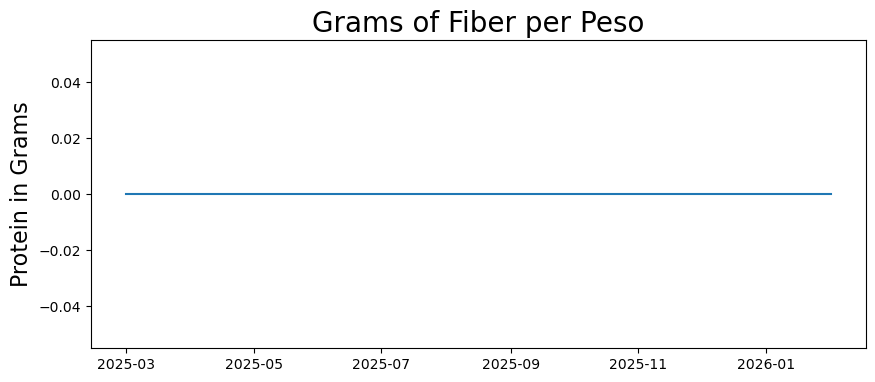

In [61]:
plt.figure(figsize=(10,4))

plt.plot(fiber_projection)

plt.title('Grams of Fiber per Peso', fontsize=20)
plt.ylabel('Protein in Grams', fontsize=16)

In [62]:
protein_projection.to_csv('./protein.csv', index=True)
carbs_projection.to_csv('./carbs.csv', index=True)
fats_projection.to_csv('./fats.csv', index=True)
fiber_projection.to_csv('./fiber.csv', index=True)